In [7]:
from pydantic import BaseModel
from openai import OpenAI
from IPython.display import display, Markdown, HTML
from collections import defaultdict
from enum import Enum
from PIL import Image as PILImage
from io import BytesIO
import itertools
import json
import uuid
import os
import base64
import re
import cv2
import numpy as np
import random
from typing import Callable

from secret_vars import OPENAI_KEY

client = OpenAI(api_key=OPENAI_KEY)

In [2]:
DISPLAY_SPOILERS = True
GENERATE_THEMES_COUNT = 3
GENERATE_RUNES_COUNT = 20
COMFYUI_PATH = "D:\AI\Flux\ComfyUI"

## Theme generation

In [3]:
class RuneTheme(BaseModel):
    name: str
    description: str

    def __hash__(self):
        return hash((self.name, self.description))

class RuneThemes(BaseModel):
    ideas: list[RuneTheme]

def generate_themes() -> RuneThemes:
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": f"I'm making a game in which mundane tasks (such as throwing out trash or doing dishes) can be separated each into multiple runes. What overarching theme can I use for coming up with those runes? Reply with a list of {GENERATE_THEMES_COUNT} propositions."},
        ],
        response_format=RuneThemes,
    )
    return completion.choices[0].message.parsed

def display_themes(themes: RuneThemes):
    if not DISPLAY_SPOILERS:
        return
    display(Markdown("\n".join(f"## {theme.name}\n{theme.description}" for theme in themes.ideas)))

themes = generate_themes()
display_themes(themes)

## Nature's Cycle
Each rune represents an element of nature that symbolizes a mundane task, such as the cycle of growth (gardening), decay (taking out the trash), or cleansing (doing dishes).
## Household Elements
Runes can be themed around elemental forces in the home, like fire (cooking), water (cleaning), earth (organizing), and air (dusting or decluttering).
## Seasonal Changes
Each task rune represents a season and its associated chores, like spring cleaning, summer gardening, fall harvesting, and winter maintenance.

## Rune generation

In [4]:
class Rune(BaseModel):
    name: str
    rune_description: str
    tasks_composed_of: str

    def stripped(self) -> str:
        return re.match("^Rune of(?: the)? (.+?)$", self.name).group(1)

    def encoded(self) -> str:
        return base64.b64encode(self.stripped().encode("ascii")).decode("ascii")

class Runes(BaseModel):
    ideas: list[Rune]

def generate_runes(themes: RuneThemes) -> Runes:
    non_duplicate_runes = defaultdict(list)
    taken_rune_names = set()
    
    i = 0
    while len(taken_rune_names) < GENERATE_RUNES_COUNT:
        theme = themes.ideas[i%len(themes.ideas)]
        
        required_rune_count = round((GENERATE_RUNES_COUNT-len(taken_rune_names))/max(1, len(themes.ideas)-i))
        if i >= len(themes.ideas):
            required_rune_count *= 2
        rune_count = required_rune_count+len(non_duplicate_runes[theme])
        runes = generate_runes_for_theme(theme, rune_count)

        for rune in runes.ideas:
            if rune.stripped() not in taken_rune_names:
                taken_rune_names.add(rune.stripped())
                non_duplicate_runes[theme].append(rune)
            if len(taken_rune_names) >= GENERATE_RUNES_COUNT:
                break

        i += 1
        if i > GENERATE_THEMES_COUNT*3:
            raise Exception("Couldn't generate runes")
    
    for theme, runes in non_duplicate_runes.items():
        display_runes(runes, theme)

    return Runes(ideas = itertools.chain(*non_duplicate_runes.values()))


def generate_runes_for_theme(theme: RuneTheme, count: int) -> Runes:
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": f"I'm making a game in which mundane tasks (such as throwing out trash or doing dishes) can be separated each into multiple runes. Come up with a list of {count} runes that follow the theme \"{theme.name}\" - {theme.description}. The name of each rune should be \"Rune of ...\". Also, for each rune give a brief descriptions what kind of tasks qualify as being \"composed of\" that rune."},
        ],
        response_format=Runes,
    )
    return completion.choices[0].message.parsed

def display_runes(runes: list[Rune], theme: RuneTheme):
    if not DISPLAY_SPOILERS:
        return
    display(Markdown(f"## {theme.name}:\n" + "\n".join(f" - **{rune.name}**: {rune.rune_description} {rune.tasks_composed_of}" for rune in runes)))

runes = generate_runes(themes)

## Nature's Cycle:
 - **Rune of Growth**: This rune symbolizes the act of nurturing and cultivating life, representing the cycle of growth in nature. It embodies the work of planting, tending to, and watching plants develop. Activities like gardening, watering plants, planting seeds, and nurturing flowers.
 - **Rune of Decay**: This rune represents the natural process of decomposition and the recycling of matter back into the earth. It emphasizes the importance of letting go of what is no longer needed. Tasks such as taking out the trash, composting food scraps, clearing out expired items from the pantry, and recycling.
 - **Rune of Cleansing**: Symbolizing the need for purification and renewal, this rune reflects the washing away of dirt and grime, bringing cleanliness to our surroundings. Doing dishes, cleaning surfaces, washing clothes, and organizing messy areas.
 - **Rune of Rest**: This rune embodies the vital process of recovery and pause in nature, highlighting the importance of rest for renewal and energy restoration. Activities like taking breaks, sleeping, meditating, or simply enjoying quiet time away from chores.
 - **Rune of Transformation**: Symbolizing the change from one state to another, this rune reflects the processes of cooking and preparing food, representing how raw ingredients become nourishing meals. Chores such as cooking, meal prep, baking, and preserving food.
 - **Rune of Reflection**: This rune signifies the importance of assessment and introspection, mirroring nature's cycles of change and growth through self-evaluation and planning. Activities like organizing, planning schedules, making to-do lists, and evaluating personal goals.
 - **Rune of Connection**: Representing the interlinked relationships in nature, this rune emphasizes the tasks that bring us together with family and friends, fostering community bonds. Hosting family dinners, participating in community clean-ups, and helping with neighborhood gatherings.

## Household Elements:
 - **Rune of Clean Water**: Represents the purifying power of water in cleaning tasks. Washing dishes, mopping floors, cleaning windows, doing laundry, and scrubbing surfaces.
 - **Rune of Cozy Fire**: Embodies the warmth and energy of fire in cooking and heating tasks. Cooking meals, baking, boiling water, lighting a fire, and preparing comfort foods.
 - **Rune of Sturdy Earth**: Symbolizes stability and organization in arranging household items. Organizing closets, rearranging furniture, decluttering rooms, and maintaining gardens.
 - **Rune of Fresh Air**: Captures the essence of air in keeping spaces fresh and dust-free. Dusting surfaces, opening windows for ventilation, sweeping, and airing out rooms.
 - **Rune of Harmonious Light**: Represents the clarity and guidance of light in illuminating tasks. Changing light bulbs, cleaning lamps, arranging lighting fixtures, and optimizing natural light.
 - **Rune of Gentle Touch**: Embodies the nurturing and caring aspect in household maintenance. Watering plants, caring for pets, smoothing out wrinkles in laundry, and arranging decorative items.

## Seasonal Changes:
 - **Rune of Spring Awakening**: Symbolizes renewal and fresh beginnings, focusing on cleaning and organizing after winter. Tasks such as deep cleaning the house, organizing closets, storing winter clothes, planting new flowers, and preparing the garden.
 - **Rune of Summer Bloom**: Represents growth and maintenance, highlighting outdoor chores and enjoyment of nature. Tasks including mowing the lawn, watering plants, harvesting fruits and vegetables, maintaining gardens, and outdoor clean-up.
 - **Rune of Autumn Harvest**: Embodies preparation and collection, emphasizing the gathering of resources and preparing for winter. Tasks like harvesting crops, preserving food, cleaning gutters, raking leaves, and preparing firewood.
 - **Rune of Winter Retreat**: Focuses on maintenance and comfort during the cold months, ensuring a cozy home and safe environment. Tasks such as shoveling snow, checking and maintaining heating systems, organizing winter gear, and decorating for holidays.
 - **Rune of Seasonal Reflection**: Encourages introspection and organization, encouraging documentation of the year’s achievements and lessons. Tasks that involve journaling, organizing paperwork, setting goals for the next season, and reflecting on personal growth.
 - **Rune of Festive Preparation**: Captures the spirit of celebration, focusing on cleaning and decorating for seasonal festivities. Tasks including decorating the home, preparing festive meals, cleaning guest areas, and shopping for seasonal decorations.
 - **Rune of Seasonal Transition**: Symbolizes the shift between seasons, emphasizing the need to adapt and prepare for change. Tasks such as switching out seasonal clothing, preparing the garden for frost, stockpiling supplies for the changing weather, and adjusting home setups.

## Generate rune sprites

### Visual concept

In [5]:
class RunePictogram(BaseModel):
    rune: str
    symbol: str

class RunePictograms(BaseModel):
    runes: list[RunePictogram]

class RuneWithPictogram(Rune):
    symbol: str

def generate_runes_pictograms(runes: Runes) -> list[RuneWithPictogram]:
    rune_names = "\n".join([rune.name for rune in runes.ideas])
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": f"What rune-like symbol/pictogram would best fit the following runes? For each rune, reply with a single answer containing max three words. Try to make each rune recognizable and distinct from the other ones. Make all your ideas \"fit\" with one another. Prefer simple symbols over intricate ones. Remember that those are supposed to be font-like characters for runes, not entire pictures.\n\n{rune_names}"},
        ],
        response_format=RunePictograms,
    )
    pictograms = completion.choices[0].message.parsed
    
    pictogram_map = {p.rune: p.symbol for p in pictograms.runes}
    return [
        RuneWithPictogram(**rune.dict(), symbol = pictogram_map.get(rune.name, rune.name))
        for rune in runes.ideas
    ]

def display_runes_pictograms(runes: list[RuneWithPictogram]):
    if not DISPLAY_SPOILERS:
        return
    display(Markdown("\n".join(f" - **{rune.name}**: {rune.symbol}" for rune in runes)))

rune_pictograms = generate_runes_pictograms(runes)
display_runes_pictograms(rune_pictograms)

 - **Rune of Growth**: Sprouting Seed
 - **Rune of Decay**: Falling Leaf
 - **Rune of Cleansing**: Water Wave
 - **Rune of Rest**: Crescent Moon
 - **Rune of Transformation**: Spiral Path
 - **Rune of Reflection**: Mirror Circle
 - **Rune of Connection**: Interlinked Circles
 - **Rune of Clean Water**: Ripple
 - **Rune of Cozy Fire**: Flame
 - **Rune of Sturdy Earth**: Mountain Peak
 - **Rune of Fresh Air**: Wind Swirl
 - **Rune of Harmonious Light**: Radiant Star
 - **Rune of Gentle Touch**: Open Hand
 - **Rune of Spring Awakening**: Blooming Flower
 - **Rune of Summer Bloom**: Sunflower
 - **Rune of Autumn Harvest**: Basket of Fruits
 - **Rune of Winter Retreat**: Snowflake
 - **Rune of Seasonal Reflection**: Seasonal Wheel
 - **Rune of Festive Preparation**: Wrapped Gift
 - **Rune of Seasonal Transition**: Two Leaves

### Initial sprite generation

In [6]:
def generate_rune_sprites(runes: list[RuneWithPictogram]):
    path_here = os.popen('powershell.exe -Command "(Get-Item .).FullName"').read().replace("\n", "")
    uid = uuid.uuid4()
    runes_str = base64.b64encode(json.dumps([rune.symbol for rune in runes]).encode("ascii")).decode("ascii")

    command = f'cd {COMFYUI_PATH}; python "{path_here}\image_gen_runes.py" --uuid "{uid}" --runes "{runes_str}"'
    full_command = f'powershell.exe -Command {json.dumps(command)}'
    os.system(full_command)

    commands = []
    for rune in runes:
        for i in range(1, 5):
            command = f'Move-Item -Path "{COMFYUI_PATH}\\output\\rune_{uid}_{rune.symbol}_0000{i}_.png" -Destination "{path_here}\\img\\{rune.encoded()}_{i}.png" -Force'
            commands.append(command)
    os.system(f'powershell.exe -Command {json.dumps("; ".join(commands))}')

generate_rune_sprites(rune_pictograms)

Total VRAM 12282 MB, total RAM 32609 MB
pytorch version: 2.5.0+cu124
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.5.0+cu124)
    Python  3.10.11 (you have 3.10.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
C:\Users\Aurif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xformers\ops\swiglu_op.py:107: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(cls, ctx, x, w1, b1, w2, b2, w3, b3):
C:\Users\Aurif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xformers\ops\swiglu_op.py:

ComfyUI found: D:\AI\Flux\ComfyUI
'D:\AI\Flux\ComfyUI' added to sys.path
Could not find the extra_model_paths config file.
ComfyUI found: D:\AI\Flux\ComfyUI
'D:\AI\Flux\ComfyUI' added to sys.path


100%|##########| 15/15 [00:20<00:00,  1.38s/it]
Requested to load AutoencodingEngine
Loading 1 new model
loaded completely 0.0 159.87335777282715 True
Requested to load FluxClipModel_
Loading 1 new model
loaded completely 0.0 4777.53759765625 True
loaded partially 9545.67451171875 9545.5224609375 0
100%|##########| 15/15 [02:16<00:00,  9.13s/it]
Requested to load AutoencodingEngine
Loading 1 new model
loaded completely 0.0 159.87335777282715 True
Requested to load FluxClipModel_
Loading 1 new model
loaded completely 0.0 4777.53759765625 True
loaded partially 9545.67451171875 9545.5224609375 0
100%|##########| 15/15 [00:15<00:00,  1.03s/it]
Requested to load AutoencodingEngine
Loading 1 new model
loaded completely 0.0 159.87335777282715 True
Requested to load FluxClipModel_
Loading 1 new model
loaded completely 0.0 4777.53759765625 True
loaded partially 9545.67451171875 9545.5224609375 0
100%|##########| 15/15 [00:24<00:00,  1.64s/it]
Requested to load AutoencodingEngine
Loading 1 new m

NameError: name 'HTML' is not defined

In [11]:
def display_raw_rune_sprites(runes: list[RuneWithPictogram], *, suffix: str = ".png"):
    if not DISPLAY_SPOILERS:
        return
    
    full_code = ""
    for rune in runes:
        img_code = "\n".join([f'<img src="img/{rune.encoded()}_{i}{suffix}?{random.randint(0, 1e7)}" style="width: 128px" />' for i in range(1, 5)])
        html_code = f"""
            <div>
                <div style="display: flex; justify-content: space-around;">
                    <span style="font-size: 1.6em; font-weight: 600">{rune.name}</span>
                </div>
                <div style="display: flex; justify-content: space-around;">
                    {img_code}
                </div>
            </div>
        """
        full_code += html_code

    full_code = f"""
        <div style="display: flex; flex-direction: row; flex-wrap: wrap; justify-content: space-around;">
            {full_code}
        </div>
    """
    display(HTML(full_code))
display_raw_rune_sprites(rune_pictograms)

### Sprite post-processing

In [17]:
def process_all_images(runes: list[RuneWithPictogram], func: Callable):
    for rune in runes:
        for i in range(1, 5):
            try:
                func(f'{rune.encoded()}_{i}')
            except Exception as e:
                print(f'{rune.encoded()}_{i}')
                raise e

def post_process_sprite(path: str):
    TARGET_SIZE = 128

    def find_segments(image: np.ndarray) -> list[np.ndarray]:
        gray = cv2.cvtColor(cv2.bitwise_not(image), cv2.COLOR_BGRA2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6,6))
        close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, close_kernel, iterations=2)

        dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        dilate = cv2.dilate(close, dilate_kernel, iterations=1)

        cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]

        return cnts

    def retain_only_largest_segment(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        segments_to_remove = []

        max_cnt = (0, None)
        for c in find_segments(image):
            area = cv2.contourArea(c)
            if area > max_cnt[0]:
                if max_cnt[1] is not None:
                    segments_to_remove.append(max_cnt[1])
                max_cnt = (area, c)
            else:
                segments_to_remove.append(c)

        for c in segments_to_remove:
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 0, 0), -1)

        return image, max_cnt[1]

    def crop_and_resize(image: np.ndarray, rect: np.ndarray) -> np.ndarray:
        x,y,w,h = cv2.boundingRect(rect)
        image = image[y:y+h, x:x+w]

        if w > h:
            resized_image = cv2.resize(image, (TARGET_SIZE, int(h*(TARGET_SIZE/w))))
        else:
            resized_image = cv2.resize(image, (int(w*(TARGET_SIZE/h)), TARGET_SIZE))

        top_padding = (TARGET_SIZE - resized_image.shape[0]) // 2
        bottom_padding = TARGET_SIZE - resized_image.shape[0] - top_padding
        left_padding = (TARGET_SIZE - resized_image.shape[1]) // 2
        right_padding = TARGET_SIZE - resized_image.shape[1] - left_padding

        padded_image = cv2.copyMakeBorder(
            resized_image,
            top_padding,
            bottom_padding,
            left_padding,
            right_padding,
            borderType=cv2.BORDER_CONSTANT,
            value=[0, 0, 0, 0]
        )

        return padded_image

    def normalize_colors(image: np.ndarray) -> np.ndarray:
        original_size = image.shape
        image = cv2.resize(image, (original_size[0]*4, original_size[1]*4))

        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
        mask = gray_image < 96
        image[mask] = [255, 255, 255, 255]
        image[~mask] = [0, 0, 0, 0]

        image = cv2.resize(image, (original_size[0], original_size[1]))
        return image
    
    def remove_small_details(image: np.ndarray) -> np.ndarray:
        image_post = cv2.copyMakeBorder(
            image,
            4, 4, 4, 4,
            borderType=cv2.BORDER_CONSTANT,
            value=[0, 0, 0, 0]
        )

        _, binary = cv2.threshold(cv2.cvtColor(image_post, cv2.COLOR_BGRA2GRAY), 128, 255, cv2.THRESH_BINARY)
        kernel = np.ones((2, 2), np.uint8)
        image_post = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

        _, binary = cv2.threshold(cv2.bitwise_not(image_post), 128, 255, cv2.THRESH_BINARY)
        kernel = np.ones((2, 2), np.uint8)
        image_post = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

        image_post = image_post[4:-4, 4:-4]

        mask = image_post < 96
        if np.count_nonzero(mask) == 0:
            return image
        
        image[mask] = [255, 255, 255, 255]
        image[~mask] = [0, 0, 0, 0]
        return image
    
    image = cv2.imread(f'img/{path}.png')
    image = normalize_colors(image)
    image, max_segment = retain_only_largest_segment(image)
    image = crop_and_resize(image, max_segment)
    image = remove_small_details(image)
    cv2.imwrite(f'img/{path}_post.png', image)

process_all_images(rune_pictograms, post_process_sprite)
display_raw_rune_sprites(rune_pictograms, suffix="_post.png")

### Sprite vectorization and stylization

In [24]:
def vectorize_sprite(path: str):
    image = cv2.imread(f"img/{path}_post.png", cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    def contour_to_path(contour: np.ndarray, style: str) -> str:
        contour = cv2.approxPolyDP(contour, 5.0, True)
        path = '<path d="M '
        for point in contour:
            x, y = point[0]
            path += f'{x},{y} '
        path += f'Z" {style}/>\n'
        return path

    with open(f"img/{path}.svg", 'w') as svg_file:
        svg_file.write('<?xml version="1.0" standalone="no"?>\n')
        svg_file.write('<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 20010904//EN"\n')
        svg_file.write(' "http://www.w3.org/TR/2001/REC-SVG-20010904/DTD/svg10.dtd">\n')
        svg_file.write('<svg xmlns="http://www.w3.org/2000/svg" version="1.1">\n')

        # Outer contour
        for i, contour in enumerate(contours):
            if hierarchy[0][i][3] != -1:
                continue
            svg_file.write(contour_to_path(contour, ' stroke="white" fill="white" mask="url(#cutout-mask)"'))
        
        svg_file.write('<mask id="cutout-mask">\n')
        svg_file.write('\t<rect x="0" y="0" width="128" height="128" fill="white" />\n')

        for i, contour in enumerate(contours):
            if hierarchy[0][i][3] == -1:
                continue # Outer contour
            elif hierarchy[0][i][3] == 0:
                fill = "black" # Holes in shape
            elif hierarchy[0][hierarchy[0][i][3]][3] == 0:
                fill = "white" # Inner elements
            else:
                continue # Overly complex, ignoring
            
            svg_file.write('\t'+contour_to_path(contour, f' stroke="white" fill="{fill}"'))

        svg_file.write('</mask>\n')
        svg_file.write('</svg>\n')

process_all_images(rune_pictograms, vectorize_sprite)
display_raw_rune_sprites(rune_pictograms, suffix=".svg")

### Sprite rating

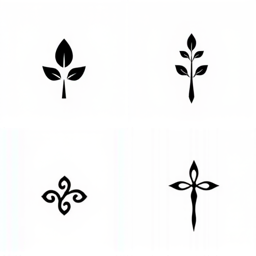

Exception: stop

In [26]:
class SpriteRating(BaseModel):
    simplicity: int
    rune_like: int
    aesthetic: int
    resemblance: int
    contains_text: bool

class SpriteRatings(BaseModel):
    top_left: SpriteRating
    top_right: SpriteRating
    bottom_left: SpriteRating
    bottom_right: SpriteRating

class RuneWithSpriteRatings(RuneWithPictogram):
    ratings: SpriteRatings

def select_sprite(rune: RuneWithPictogram) -> RuneWithSpriteRatings:
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"The attached image is a 2x2 grid of symbols, each occuppying one quadrant. Rate each of the symbols from 1 to 7 in each of the following categories:\n- simplicity of the design, with 7 being a very simple design, and 1 being overly complex\n- similarity to celtic runes or egyptian hieroglyphs, with 7 meaning it fits well with them, and 1 meaning it doesn't fit at all\n - the aesthetic design of the symbol, with 7 being very pretty and well designed one, and 1 being a very poorly designed one\n - resemblance of {rune.stripped()}, with 7 meaning it can be unmistakenly interpreted as {rune.stripped()}, and 1 meaning it has no correlation with {rune.stripped()}\n- identify if that quadrant of the image contains any text",                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url":  f"data:image/png;base64,{prepare_sprite_grid(rune)}",
                            "detail": "high"
                        },
                    },
                ],
            }
        ],
        response_format=SpriteRatings
    )

    rating = response.choices[0].message.parsed
    rune = RuneWithSpriteRatings(**rune.dict(), ratings=rating)
    return rune
    # sprite_id = {PositionEnum.top_left: 1, PositionEnum.top_right: 2, PositionEnum.bottom_left: 3, PositionEnum.bottom_right: 4}[selected_sprite]
    # sprite = encode_image(PILImage.open(f"img/{rune.encoded()}_{sprite_id}.png"))
    # return RuneWithSprite(**rune.dict(), sprite=sprite)

def prepare_sprite_grid(rune: RuneWithPictogram) -> str:
    images = [PILImage.open(f"img/{rune.encoded()}_{i}.png").resize((128, 128)) for i in range(1, 5)]

    grid_image = PILImage.new("RGBA", (256, 256))
    grid_image.paste(images[0], (0, 0))        # Top-left
    grid_image.paste(images[1], (128, 0))      # Top-right
    grid_image.paste(images[2], (0, 128))      # Bottom-left
    grid_image.paste(images[3], (128, 128))    # Bottom-right

    grid_image.show()
    raise Exception("stop")

    return encode_image(grid_image)

def encode_image(img: PILImage) -> str:
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def display_sprites_ratings(rune: RuneWithSpriteRatings):
    if not DISPLAY_SPOILERS:
        return
    
    ratings = [rune.ratings.top_left, rune.ratings.top_right, rune.ratings.bottom_left, rune.ratings.bottom_right]
    ratings = ["\n".join([f"{k}: {v}" for k, v in r.dict().items()]) for r in ratings]
    img_code = "".join([
        f"""
        <div style="display: flex; flex-direction: row;">
            <img src="img/{rune.encoded()}_{i}.png" style="width: 196px" />
            <div style="white-space: pre; margin-left: 8px; font-size: 16px">{ratings[i-1]}</div>
        </div>
        """
        for i in range(1, 5)
    ])
    full_code = f"""
        <div style="display: flex; justify-content: space-around;">
            <span style="font-size: 1.6em; font-weight: 600">{rune.name}</span>
        </div>
        <div style="display: flex; flex-direction: row; flex-wrap: wrap; justify-content: space-around;">
            {img_code}
        </div>
    """
    display(HTML(full_code))

# def display_rune_sprites(runes: list[RuneWithSprite]):
#     if not DISPLAY_SPOILERS:
#         return
    
#     img_code = "".join([
#         f'<img src="data:image/png;base64, {rune.sprite}" style="width: 128px" />'
#         for rune in runes
#     ])
#     full_code = f"""
#         <div style="display: flex; flex-direction: row; flex-wrap: wrap; justify-content: space-around;">
#             {img_code}
#         </div>
#     """
#     display(HTML(full_code))


runes_with_ratings = [select_sprite(rune) for rune in rune_pictograms[:1]]
for rune in runes_with_ratings:
    display_sprites_ratings(rune)

In [114]:
from functools import cmp_to_key


def display_sprites_ratings(rune: RuneWithSpriteRatings):
    if not DISPLAY_SPOILERS:
        return
    
    def serialize_ratings(r: SpriteRating) -> str:
        return "\n".join([f"{k}: {v}" for k, v in r.dict().items()])
    
    def compare_ratings(r1: tuple[int, SpriteRating], r2: tuple[int, SpriteRating]) -> int:
        r1: SpriteRating = SpriteRating(**r1[1].dict())
        r2: SpriteRating = SpriteRating(**r2[1].dict())

        if r1.contains_text and not r2.contains_text:
            return -1
        if r2.contains_text and not r1.contains_text:
            return 1
        
        if r1.simplicity == 7:
            r1.simplicity = 1
        if r2.simplicity == 7:
            r2.simplicity = 1

        def score(r: SpriteRating) -> int:
            return r.simplicity * 1.6 + r.rune_like + r.aesthetic + r.resemblance

        return score(r1) - score(r2)

    ratings = [(1, rune.ratings.top_left), (2, rune.ratings.top_right), (3, rune.ratings.bottom_left), (4, rune.ratings.bottom_right)]
    ratings.sort(key=cmp_to_key(compare_ratings), reverse=True)

    img_code = "".join([
        f"""
        <div style="display: flex; flex-direction: row;">
            <img src="img/{rune.encoded()}_{r[0]}.png" style="width: 196px" />
            <div style="white-space: pre; margin-left: 8px; font-size: 16px">{serialize_ratings(r[1])}</div>
        </div>
        """
        for r in ratings
    ])
    full_code = f"""
        <div style="display: flex; justify-content: space-around;">
            <span style="font-size: 1.6em; font-weight: 600">{rune.name}</span>
        </div>
        <div style="display: flex; flex-direction: row; flex-wrap: wrap; justify-content: space-around;">
            {img_code}
        </div>
    """
    display(HTML(full_code))

for rune in runes_with_ratings:
    display_sprites_ratings(rune)